In [3]:
import vtk
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support
import os
import numpy
import plotly
from plotly.graph_objs import *
plotly.plotly.sign_in("maroubenm", "MYtwtr0twNnh46fu2R9f")

In [4]:
def vtkImageToNumPy(image, pixelDims):
    pointData = image.GetPointData()
    arrayData = pointData.GetArray(0)
    ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
    ArrayDicom = ArrayDicom.reshape(pixelDims, order='F')
    return ArrayDicom

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [5]:
"""class MyInteractorStyle(vtk.vtkInteractorStyleTrackballCamera):

    def __init__(self, parent=None):
        self.AddObserver("MiddleButtonPressEvent", self.middle_button_press_event)
        self.AddObserver("MiddleButtonReleaseEvent", self.middle_button_release_event)

    def middle_button_press_event(self, obj, event):
        print("Middle Button pressed")
        self.OnMiddleButtonDown()
        return

    def middle_button_release_event(self, obj, event):
        print("Middle Button released")
        self.OnMiddleButtonUp()
        return"""

'class MyInteractorStyle(vtk.vtkInteractorStyleTrackballCamera):\n\n    def __init__(self, parent=None):\n        self.AddObserver("MiddleButtonPressEvent", self.middle_button_press_event)\n        self.AddObserver("MiddleButtonReleaseEvent", self.middle_button_release_event)\n\n    def middle_button_press_event(self, obj, event):\n        print("Middle Button pressed")\n        self.OnMiddleButtonDown()\n        return\n\n    def middle_button_release_event(self, obj, event):\n        print("Middle Button released")\n        self.OnMiddleButtonUp()\n        return'

In [6]:
class MouseInteractorHighLightActor(vtk.vtkInteractorStyleTrackballCamera):
    
    def __init__(self,parent=None):
        
        self.AddObserver("LeftButtonPressEvent",self.leftButtonPressEvent)
        self.LastPickedActor = None
        self.LastPickedProperty = vtk.vtkProperty()
 
    def leftButtonPressEvent(self,obj,event):
        
        clickPos = self.GetInteractor().GetEventPosition()
        picker = vtk.vtkPropPicker()
        picker.Pick(clickPos[0], clickPos[1], 0, self.GetDefaultRenderer())
        
        #point.InsertNextPoint(clickPos[0],clickPos[1],0)
        
        #print  clickPos
        
        
        # get the new
        self.NewPickedActor = picker.GetActor()
        
        # If something was selected
        if self.NewPickedActor:
            # If we picked something before, reset its property
            if self.LastPickedActor:
                self.LastPickedActor.GetProperty().DeepCopy(self.LastPickedProperty)
    
            
            # Save the property of the picked actor so that we can
            # restore it next time
            self.LastPickedProperty.DeepCopy(self.NewPickedActor.GetProperty())
            # Highlight the picked actor by changing its properties
            self.NewPickedActor.GetProperty().SetColor(1.0, 0.0, 0.0)
            self.NewPickedActor.GetProperty().SetDiffuse(1.0)
            self.NewPickedActor.GetProperty().SetSpecular(0.0)
            
            # save the last picked actor
            self.LastPickedActor = self.NewPickedActor
        
        self.OnLeftButtonDown()
        return


In [7]:
def plotHeatmap(array, name="plot"):
    data = Data([ Heatmap( z=array,colorscale='Greys')])
    layout = Layout(autosize=False,title=name)
    fig = Figure(data=data,layout=layout)
    return plotly.plotly.iplot(fig,filename=name)

In [8]:
import vtk
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

In [9]:
PathDicom = "D:\\aorte private data\\hips\\Pelvis"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()
                          
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]
ConstPixelSpacing = reader.GetPixelSpacing()

In [10]:
ArrayDicom = vtkImageToNumPy(reader.GetOutput(), ConstPixelDims)
plotHeatmap(numpy.rot90(ArrayDicom[:,:,0]), name="CT_Original")

C:\Users\hp\Anaconda3\envs\python2\lib\site-packages\plotly\graph_objs\_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~maroubenm/0 or inside your plot.ly account where it is named 'CT_Original'


In [11]:
'''threshold = vtk.vtkImageThreshold ()
threshold.SetInputConnection(reader.GetOutputPort())
threshold.ThresholdByLower(400)  # remove all soft tissue
threshold.ReplaceInOn()
threshold.SetInValue(0)  # set all values below 400 to 0
threshold.ReplaceOutOn()
threshold.SetOutValue(1)  # set all values above 400 to 1
threshold.Update()'''

'threshold = vtk.vtkImageThreshold ()\nthreshold.SetInputConnection(reader.GetOutputPort())\nthreshold.ThresholdByLower(400)  # remove all soft tissue\nthreshold.ReplaceInOn()\nthreshold.SetInValue(0)  # set all values below 400 to 0\nthreshold.ReplaceOutOn()\nthreshold.SetOutValue(1)  # set all values above 400 to 1\nthreshold.Update()'

In [12]:
 %%time
contourBoneHead = vtk.vtkMarchingCubes()
contourBoneHead.SetInputConnection( reader.GetOutputPort() )
contourBoneHead.ComputeNormalsOn()
contourBoneHead.ComputeScalarsOn()
contourBoneHead.SetValue( 0,350)

Wall time: 1e+03 µs


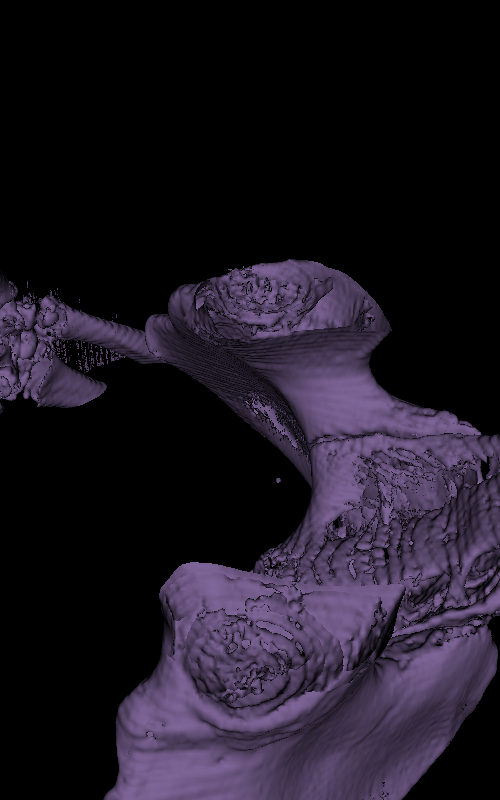

In [13]:

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(contourBoneHead.GetOutputPort())

actor = vtk.vtkActor()

actor.SetMapper(mapper)
actor.GetMapper().ScalarVisibilityOff()
actor.GetProperty().SetColor(.5, .4, 0.6)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0, 0, 0)

camera = renderer.MakeCamera()
camera.SetPosition(-100.0, 245.5, 500.0)
camera.SetFocalPoint(301.0, 245.5, 122.0)
camera.SetViewAngle(30)
camera.SetRoll(90)
renderer.SetActiveCamera(camera)
vtk_show(renderer, 500 ,800)

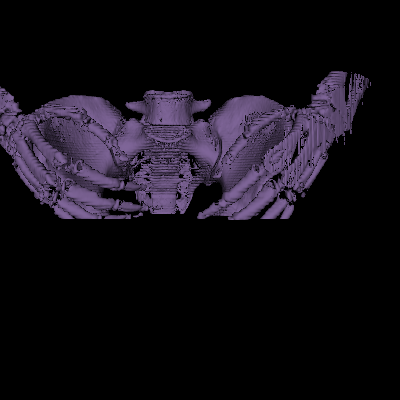

In [14]:
camera = renderer.GetActiveCamera()
camera.SetPosition(301.0, 1045.0, 122.0)
camera.SetFocalPoint(301.0, 245.5, 122.0)
camera.SetViewAngle(30.0)
camera.SetRoll(0.0)
renderer.SetActiveCamera(camera)
vtk_show(renderer, 400, 400)

In [15]:
writer = vtk.vtkSTLWriter()
writer.SetInputConnection(contourBoneHead.GetOutputPort())
writer.SetFileTypeToBinary()
writer.SetFileName("hips_pelvis.stl")
writer.Write()

1

In [ ]:
renderer_window = vtk.vtkRenderWindow()
renderer_window.AddRenderer(renderer) 
renderer_interactor = vtk.vtkRenderWindowInteractor()
#style = MouseInteractorHighLightActor()
#style.SetDefaultRenderer(renderer)
#renderer_interactor.SetInteractorStyle(style)

renderer_interactor.SetRenderWindow(renderer_window)
renderer.SetBackground(1,1,1)
renderer_window.SetSize(500,600)
renderer_interactor.Initialize()
renderer_window.Render()
renderer_interactor.Start()